In [1]:
# Display the output of plotting commands inline
%matplotlib inline

In [2]:
# Import python modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import sys

# Load 'helper utilities'
from linkage_tools import *
l = Linker()

# Load classifier objects
from Probabilistic import *
from Perceptron import *
from NeuralNetwork import *

#import warnings
#warnings.filterwarnings('error')

In [3]:
# Set print output toggle
verbose = True

### Define linking variables

In [4]:
# Define tables
tableA = '''patient_discharges JOIN newborns
ON patient_discharges.id = newborns.patient_discharge_id
LEFT OUTER JOIN patient_payers AS newborn_payers
ON newborn_payers.patient_discharge_id = patient_discharges.id'''

tableB = '''births JOIN deliveries 
ON births.delivery_id = deliveries.id
JOIN patient_discharges AS delivery_discharges
ON deliveries.patient_discharge_id = delivery_discharges.id
LEFT OUTER JOIN patient_payers AS delivery_payers
ON delivery_payers.patient_discharge_id = delivery_discharges.id'''

# Define fields to compare tables by
tableA_fields = ['patient_discharges.sex_id','newborns.id','newborns.cesarean_section', 
            'patient_discharges.zip_code','patient_discharges.race_id','patient_discharges.ethnicity_id', 
                'newborn_payers.payer_type_of_coverage_id','patient_discharges.principal_language_spoken', 
                 'patient_discharges.discharged_on','newborn_payers.payer_category_id',
                 'newborn_payers.plan_code_number','newborns.birth_weight_group_id',
                 'newborns.gestational_age_group_id','newborns.plurality_group_id']

tableB_fields = ['births.sex_id','births.newborn_id','births.delivery_route_id', 
            'births.mothers_residence_zip_code','delivery_discharges.race_id','delivery_discharges.ethnicity_id', 
                'delivery_payers.payer_type_of_coverage_id','delivery_discharges.principal_language_spoken', 
                 'delivery_discharges.discharged_on','delivery_payers.payer_category_id',
                 'delivery_payers.plan_code_number','births.birth_weight',
                 'births.gestational_age_ob_estimate','births.plurality'] 

# Define new names for each comparison
simple_feature_names = ['sex_id','c_section','zip_code','race','ethnicity','payer_type_of_coverage_id',
                'language_spoken','discharge','payer_category_id','plan_code_number','plurality']

complex_feature_names = ['weight_group_id','gest_age_group_id']

simple_feature_num = 11

# Exact matching only
simple_features = [val for pair in zip([x+'_match' for x in simple_feature_names],
                                    [x+'_nomatch' for x in simple_feature_names]) for val in pair]

# Including non-exact matching
complex_features = [val for pair in zip([x+'_match' for x in complex_feature_names],
                     [x+'_fuzzymatch' for x in complex_feature_names],
                     [x+'_nomatch' for x in complex_feature_names]) for val in pair]

feature_vals = simple_features + complex_features

# Define bins to use for certain fields
age_bins = np.concatenate(([0,1,24], np.arange(25, 36, 2),[99]), axis=0)
bw_bins = np.concatenate(([1], np.arange(500, 2001, 250),[2500,9999]), axis=0)

cesarean_ids = [1, 11, 21, 31, 2, 12, 22, 32]

In [5]:
def get_condition_vals(cross_table):
    condition_vals = [  (cross_table['sex_id_x'],cross_table['sex_id_y']),
                (cross_table['cesarean_section'],
                 pd.Series([x in cesarean_ids for x in cross_table['delivery_route_id']])),
                (cross_table['zip_code'],cross_table['mothers_residence_zip_code']),
                (cross_table['race_id_x'],cross_table['race_id_y']),
                (cross_table['ethnicity_id_x'],cross_table['ethnicity_id_y']),
                (cross_table['payer_type_of_coverage_id_x'],cross_table['payer_type_of_coverage_id_y']),
                ((cross_table['principal_language_spoken_x'].str[:3]).str.lower(),
                 (cross_table['principal_language_spoken_y'].str[:3]).str.lower()),
                (cross_table['discharged_on_x'],cross_table['discharged_on_y']),
                (cross_table['payer_category_id_x'],cross_table['payer_category_id_y']),
                (cross_table['plan_code_number_x'],cross_table['plan_code_number_y']),
                ((cross_table['plurality_group_id']==1),(cross_table['plurality']==1)),
                (cross_table['birth_weight_group_id'],
                     l.digitize_series(cross_table['birth_weight'],bw_bins)),
                (cross_table['gestational_age_group_id'],
                     l.digitize_series(cross_table['gestational_age_ob_estimate']/7,age_bins))  ] 
    return(condition_vals)

def getBools(cross_table):
    
    def bool_test(condition_val_pair):
        # Exact matching of fields
        condA,condB = condition_val_pair
        fields_notnull = np.logical_and(condA.notnull(),condB.notnull())
        return(np.vstack([np.array(condA==condB)&fields_notnull,
                          np.array((condA!=condB)&fields_notnull)]))
    
    def bool_test_complex(condition_val_pair):
        # 'Fuzzy' matching of fields
        condA,condB = condition_val_pair
        fields_notnull = np.logical_and(condA.notnull(),condB.notnull())
        return(np.vstack([np.squeeze(np.diff(zip(condA*1.0,condB*1.0))==0)&fields_notnull,
                          np.squeeze(np.diff(zip(condA*1.0,condB*1.0))==1)&fields_notnull,
                          np.squeeze(np.diff(zip(condA*1.0,condB*1.0))>1)&fields_notnull]))
    
    condition_vals = get_condition_vals(cross_table)
    simple_bools = [bool_test(x) for x in condition_vals[0:simple_feature_num]] # Simple features
    complex_bools = [bool_test_complex(x) for x in condition_vals[simple_feature_num:]] # Complex features

    return(np.concatenate(simple_bools+complex_bools).T)

#def getMissing(cross_table):
#    def none_test(condition_val_pair):
#        condA,condB = condition_val_pair
#        aNones = [x is None for x in condA]
#        bNones = [x is None for x in condB]
#        return(np.vstack([np.logical_or(aNones,bNones),np.logical_or(aNones,bNones)]))
#   condition_vals = get_condition_vals(cross_table)
#    return(np.concatenate([none_test(x) for x in condition_vals]).T)

### Blocking

In [6]:
# Find all possible values for 1st blocking field ('hospital_id')
stmt = '''
SELECT DISTINCT patient_discharges.hospital_id
FROM patient_discharges 
UNION
SELECT DISTINCT births.hospital_id
FROM births;'''
block_list1 = [x[0] for x in l.exec_sql(stmt).values.tolist()]

block_list1 = block_list1[0:2]

# Find all possible values for 2nd blocking field ('date_of_delivery')
stmt = '''
SELECT DISTINCT births.date_of_delivery
FROM births;'''
block_list2 = [x[0] for x in l.exec_sql(stmt).values.tolist()]

block_list2 = block_list2[600:650]

block_prod = [(str(x),str(y)) for x in block_list1 for y in block_list2]

# Assign strings to select each block
blocking_stmt1 = '''
        SELECT patient_discharges.id AS pdd_id, newborns.id AS newb_id,%s 
        FROM %s
        WHERE patient_discharges.hospital_id = %r
        AND patient_discharges.date_of_birth = %r;
        '''
blocking_stmt2 = '''
        SELECT births.id AS bc_id,%s
        FROM %s
        WHERE births.hospital_id = %r
        AND births.date_of_delivery = %r;
        '''

### Create classifiers and iterate over each block
- Create [probabilistic] and [perceptron] classifier (train each on selected subset of features ['simple' vs. 'complex'])
- Loop over each block and convert to pandas dataframe
- Cross join the features-of-interest from both blocks
- Apply conditional statements to each column of dataframe
- Return match score from each learner
- Maximize pairing with Kuhn-Munkres (i.e. Hungarian) Algorithm [more info]
- Compare guesses to truth, update weights/probabilities

[more info]: https://pypi.python.org/pypi/munkres/
[perceptron]: http://glowingpython.blogspot.com/2011/10/perceptron.html
[probabilistic]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5005943/

In [7]:
learning_rate_pt = 0.01 # small, constant learning rate for perceptron
learning_rate_nn = 0.1

# Create instances of classifiers
classifiers = [Probabilistic(simple_features),
                Probabilistic(feature_vals),
                Perceptron(simple_features,learningrate = learning_rate_pt),
                Perceptron(feature_vals,learningrate = learning_rate_pt),
                NeuralNetwork(feature_vals,10,1,learningrate = learning_rate_nn)]

classifier_names = ['pr_simple','pr_complex','pt_simple','pt_complex','nn_complex']

#classifier_features = [simple_features,feature_vals,simple_features,feature_vals,feature_vals]
class_prog = [True] * len(classifiers)

iter_qual_list = []
iter_score_list = []
block_duration = []
epoch_duration = []
epoch_count = 0
verb_str = '\rEpoch #{}, blockA: {} records, blockB: {} records  ' # verbose output

while True:
    epoch_start = time.time() # Measure epoch duration
    big_bool = pd.DataFrame(columns=feature_vals)  

    for block1, block2 in block_prod:
        
        block_start = time.time() # Measure block duration

        # Create blocks
        blockA = l.exec_sql(blocking_stmt1 % (",".join(tableA_fields),tableA,block1,block2))
        blockB = l.exec_sql(blocking_stmt2 % (",".join(tableB_fields),tableB,block1,block2))
        
        if verbose:
            sys.stdout.write(verb_str.format(epoch_count+1, len(blockA), len(blockB)))
            sys.stdout.flush()
            
        # Check that neither block is empty - If empty, skip to next record-pair in loop
        if (len(blockA)==0) or (len(blockB)==0):
            continue

        # Cross-join both blocks
        cross_table = l.df_crossjoin(blockA, blockB)

        # Count field matches and dump each into new column of dataframe
        bool_table = pd.DataFrame.from_items(zip(feature_vals,getBools(cross_table).T))
        # bool_table = pd.DataFrame.from_items(zip(feature_vals,[eval(x).values for x in conditions]))

        # Add record-id columns to boolean table
        bool_table['newb_id'] = cross_table['newb_id'].values # Actual newborn id
        bool_table['bc_id'] = cross_table['bc_id'].values  # Actual bc id
        bool_table['prev_newb_id'] = cross_table['newborn_id'].values # Originally matched newborn id 
        
        # Compare with previously-linked newborn id
        bool_table['real_match'] = (cross_table['newborn_id']==cross_table['newb_id']).values 
        for x in classifier_names:
            bool_table['match_'+x] = False # Create new columns for later
        
        # STILL NEED TO RE-DISTRIBUTE THE WEIGHTS FOR MISSING VALUES-
        # Get guesses from classifiers
        record_id = bool_table[['newb_id','bc_id']]
        for x,y in zip(classifiers,classifier_names):
            link_inds,link_score = x.query(bool_table[x.features],record_id) 
            bool_table['lscore_'+y] = link_score
            bool_table.loc[link_inds,'match_'+y] = True # Label nominees as such  
        
        # Aggregate field-match tables (Booleans) within loop
        big_bool = pd.concat([big_bool,bool_table])
    
        # Time duration of each block
        block_duration.append(time.time()-block_start)
        
    # Check progress of each classifier 
    classifiers_masked = [elem for elem,z in zip(classifiers,class_prog) if z==True]
    classifier_names_masked = [elem for elem,z in zip(classifier_names,class_prog) if z==True]
    
    # Train classifiers (if still progressing)
    train_classifier = lambda x,y: x.train(big_bool[x.features],big_bool['real_match'],big_bool['match_'+y])
    map(train_classifier,classifiers,classifier_names)
    
    # Measure accuracy of each classifier
    score_list = [((big_bool['match_'+x]==big_bool['real_match'])*1).tolist() for x in classifier_names]
    cur_scores = [sum(x)*100.0/len(x) for x in score_list]
    iter_score_list.append(cur_scores)
    
    # Set range of linkage scores (0 through 100 percentiles) i.e. decision threshold (theta)
    set_thetas = range(0,100,10)
    
    # Update precision & recall of classifiers
    for x,y in zip(classifiers,classifier_names):
        x.prec_recall(big_bool['lscore_'+y],set_thetas,big_bool['real_match'])
    
    # Compare current iteration 'quality' with previous iterations
    cur_iter_qual = [x.iter_qual_list[-1] for x in classifiers]
    prev_iter_qual = [x.iter_qual_list[-2] for x in classifiers]
    class_prog = np.subtract(cur_iter_qual,prev_iter_qual)>.1
    iter_qual_list.append(cur_iter_qual)
    
    # If not improving > Break from outer loop
    if not any(class_prog):
        print str.format('\n'+'-'*80+"\n'Quality' achieved! @ {}",[ float('%.2f' % x) for x in cur_iter_qual ])        
        break

    # Time duration of each iteration
    epoch_duration.append(time.time()-epoch_start)
    
    epoch_count += 1 # Increment epoch counter
    
    if verbose:
        print str.format('\nAverage block duration: {0:.2f} seconds', np.mean(block_duration))
        print str.format("'Quality': {}", [ float('%.2f' % x) for x in cur_iter_qual ])
        print str.format('% correct: {}', [ float('%.4f' % x) for x in cur_scores ])
        print str.format('Average epoch duration: {0:.3f} minutes', np.mean(epoch_duration)/60.0)

Epoch #1, blockA: 23 records, blockB: 23 records  
Average block duration: 0.37 seconds
'Quality': [103.59, 86.43, 75.1, 76.63, 76.54]
% correct: [91.6928, 91.9696, 91.3045, 92.2216, 92.6058]
Average epoch duration: 0.806 minutes
Epoch #2, blockA: 23 records, blockB: 23 records  
Average block duration: 0.32 seconds
'Quality': [157.28, 158.36, 156.2, 150.26, 157.06]
% correct: [99.8843, 99.8926, 99.8596, 99.8058, 99.8596]
Average epoch duration: 0.713 minutes
Epoch #3, blockA: 23 records, blockB: 23 records  
Average block duration: 0.29 seconds
'Quality': [157.28, 158.36, 156.2, 151.83, 158.11]
% correct: [99.8843, 99.8926, 99.8761, 99.843, 99.8761]
Average epoch duration: 0.674 minutes
Epoch #4, blockA: 23 records, blockB: 23 records  
Average block duration: 0.28 seconds
'Quality': [157.28, 158.36, 156.2, 153.86, 158.32]
% correct: [99.8843, 99.8926, 99.8678, 99.8348, 99.8678]
Average epoch duration: 0.659 minutes
Epoch #5, blockA: 23 records, blockB: 23 records  
------------------

### Plot precision/recall for each epoch of probabilistic record linkage

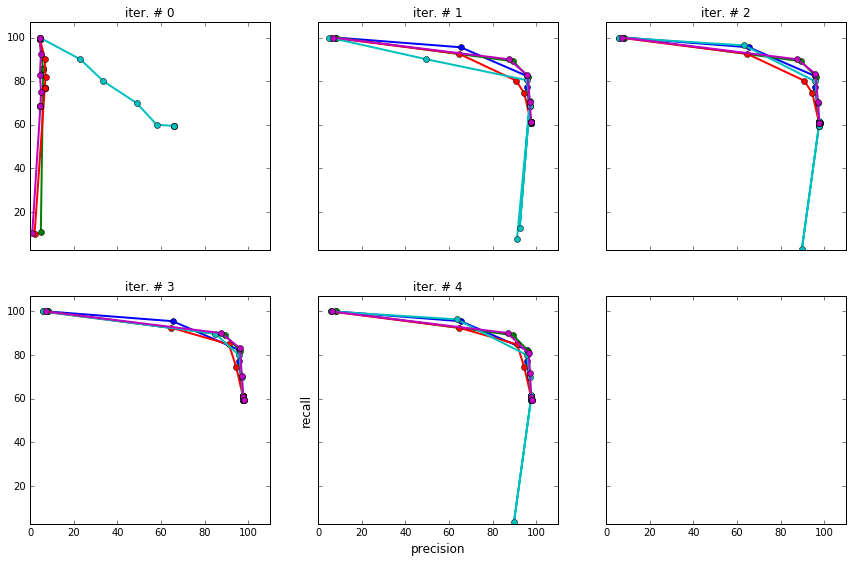

In [8]:
plot_prec_list = [o.precision_list for o in classifiers]
plot_recall_list = [o.recall_list for o in classifiers]
color_list = ['b','g','r','c','m'][slice(len(classifiers))]

ncol = int(np.ceil(np.sqrt(len(plot_prec_list[0]))))
nrow = int(np.ceil(len(plot_recall_list[0])/float(ncol)))
fig, axs = plt.subplots(nrow, ncol, sharex='col', sharey='row')
for i, ax in enumerate(fig.axes[0:len(plot_prec_list[0])]):   
    plot_curves = lambda w,x,y: ax.plot(w[i], x[i], '-', linewidth=2, marker='o', color=y)
    map(plot_curves,plot_prec_list,plot_recall_list,color_list)
    ax.set_xlim([0,110])
    ax.set_ylim([0,110])
    ax.set_title("iter. # {}".format(str(i)), fontsize=12)
    ax.set(aspect='equal')    
else:
    ax.set_xlabel('precision', fontsize=12)
    ax.set_ylabel('recall', fontsize=12)

fig.set_size_inches(4.875*ncol,4.5*nrow)
plt.show()
fig.savefig('prec_recall.png')

### Plot accuracy for each classifier over all epochs

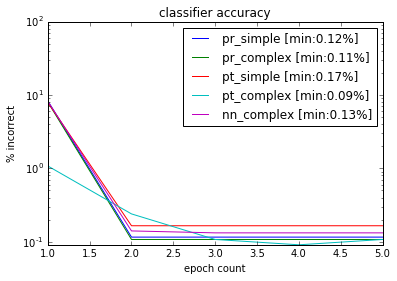

In [14]:
x = range(1,epoch_count+2)
y = 100-np.array(iter_score_list, ndmin=2, dtype=np.float).T
fig = plt.figure()
plt.yscale('log')
plt.ylim((y.min(),100))
plt.title("classifier accuracy")
for quals,cl,col in zip(y,classifier_names,color_list):
    plt.plot(x,quals,label = cl+' [min:'+str('%.2f' % quals.min())+'%]',color=col)
plt.xlabel("epoch count")
plt.ylabel("% incorrect")
plt.legend(loc='upper right')
plt.show()

fig.savefig('classifier_accuracy.png')

### Show table of weights/probabilities for each classifier

In [15]:
import itable

# Assemble table elements into dataframe
pt_simple_weights = classifiers[2].weights.tolist()[:-1] + \
    [None]*len(complex_features) + [classifiers[2].weights.tolist()[-1]]

weight_list = [['prob_simple'] + classifiers[0].m_probs.tolist() + [None],
               ['prob_complex'] + classifiers[1].m_probs.tolist() + [None],
               ['perc_simple'] + pt_simple_weights,
               ['perc_complex'] + classifiers[3].weights.tolist()]
df = pd.DataFrame(weight_list, columns=['classifier']+feature_vals+['bias'])

# Save table as html file
my_file = open('weights.html', 'w')
my_file.write(df.to_html())
#pt_simple_weights = classifiers[2].weights.tolist()
my_file.close()

# Show table as ipython figure
itable.PrettyTable(df)

classifier,sex_id_match,sex_id_nomatch,c_section_match,c_section_nomatch,zip_code_match,zip_code_nomatch,race_match,race_nomatch,ethnicity_match,ethnicity_nomatch,payer_type_of_coverage_id_match,payer_type_of_coverage_id_nomatch,language_spoken_match,language_spoken_nomatch,discharge_match,discharge_nomatch,payer_category_id_match,payer_category_id_nomatch,plan_code_number_match,plan_code_number_nomatch,plurality_match,plurality_nomatch,weight_group_id_match,weight_group_id_fuzzymatch,weight_group_id_nomatch,gest_age_group_id_match,gest_age_group_id_fuzzymatch,gest_age_group_id_nomatch,bias
prob_simple,0.981024667932,0.0185009487666,0.992409867173,0.00759013282732,0.895161290323,0.103889943074,0.890891840607,0.102466793169,0.933586337761,0.0645161290323,0.0,0.0,0.916034155598,0.0787476280835,0.890417457306,0.109582542694,0.0,0.0,0.0,0.0,0.996204933586,0.00379506641366,nan,nan,nan,nan,nan,nan,nan
prob_complex,0.981024667932,0.0185009487666,0.992409867173,0.00759013282732,0.895161290323,0.103889943074,0.890891840607,0.102466793169,0.933586337761,0.0645161290323,0.0,0.0,0.916034155598,0.0787476280835,0.890417457306,0.109582542694,0.0,0.0,0.0,0.0,0.996204933586,0.00379506641366,0.076375711575,0.00569259962049,0.000474383301708,0.0445920303605,0.0716318785579,0.00189753320683,nan
perc_simple,14.9756052578,-14.9821836876,0.165228567641,-0.165705402598,16.9466069364,-16.9343576373,15.8023694142,-15.8127165231,12.6697030038,-12.6692080655,0.00902179801272,0.00555401178594,3.33025667212,-3.33002813906,2.00377015014,-2.01972945706,0.00178702274153,-0.00532458834501,0.000680941094566,0.00224023011689,1.95375899456,-1.95284294058,nan,nan,nan,nan,nan,nan,0.00894549382414
perc_complex,0.625412755749,-0.617133943728,1.26053665737,-1.25903667607,1.69771383109,-1.68794997676,0.238962895236,-0.247801759969,0.114620767972,-0.112326890011,-0.00770795103945,0.00970571567555,0.231849030812,-0.230658364141,0.807780056103,-0.796405555595,-0.00487802246161,-0.0040530087758,-0.000670760572659,-0.00100497836549,1.91322063187,-1.91371700726,0.563531152275,-0.189731123446,-0.29415407207,-0.00994070815628,0.420105650789,-0.357070636284,0.00102084488835


### Organize and export 'wrong answers' to spreadsheet (.csv) files [1 spreadsheet/classifier]

In [16]:
import csv

# Select features to export
feature_list = ['bc_id','real_match','newb_id']+feature_vals

# Gather incorrect matches for each classifier
score_list = [((big_bool['match_'+x]==big_bool['real_match'])*1).tolist() for x in classifiers]

for sc,cl in zip(score_list,classifiers):
    errors = big_bool[feature_list].iloc[[x==0 for x in sc],:].sort(['bc_id','real_match'], ascending=[1,0])
    errors.to_csv('linkage_error_'+cl+'.csv')

TypeError: cannot concatenate 'str' and 'instance' objects